<a href="https://colab.research.google.com/github/Chief-Blackhood/cautious-invention/blob/main/IRE_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers

In [ ]:
!nvidia-smi

Mon Nov 15 05:54:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

device = torch.device("cuda")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
train = pd.read_csv("train.tsv", sep='\t', names=["text", "label"])
dev = pd.read_csv("dev.tsv", sep='\t', names=["text", "label"])
test = pd.read_csv("test.tsv", sep='\t', names=["text", "label"])

In [ ]:
def change_label(df):
  df.loc[df['label'] >= 0.8, 'label'] = 1
  df.loc[df['label'] < 0.8, 'label'] = 0
  df['label'] = df['label'].astype(int)

In [ ]:
for df in [train, dev, test]:
  change_label(df)

In [ ]:
def class_distribution(df):
  print(df['label'].value_counts(normalize=True))

In [ ]:
for df in [train, dev, test]:
  class_distribution(df)

0    0.611486
1    0.388514
Name: label, dtype: float64
0    0.611467
1    0.388533
Name: label, dtype: float64
0    0.615584
1    0.384416
Name: label, dtype: float64


### Import BERT Model and Tokenizer

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tokenization

#### Histogram to find length

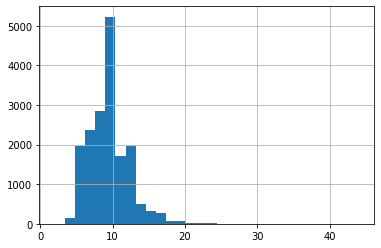

In [ ]:
text_len = [len(tokenizer.tokenize(t)) for t in train['text']]
pd.Series(text_len).hist(bins=30)

In [ ]:
# since 25 length text covers most of the sentences
max_seq_len = 25

#### Tokenize and Encode

In [ ]:
def tok_enc_seq(text):
  return tokenizer.batch_encode_plus(text.tolist(), max_length=max_seq_len, padding='max_length', truncation=True, return_token_type_ids=False)

In [ ]:
tokens_train = tok_enc_seq(train['text'])
tokens_dev = tok_enc_seq(dev['text'])
tokens_test = tok_enc_seq(test['text'])

### Interger Sequences -> Tensors

In [ ]:
def int_to_tensor(tokens, df):
  seq = torch.tensor(tokens['input_ids'])
  mask = torch.tensor(tokens['attention_mask'])
  y = torch.tensor(df['label'].tolist())
  return seq, mask, y

In [ ]:
train_seq, train_mask, train_y = int_to_tensor(tokens_train, train)
dev_seq, dev_mask, dev_y = int_to_tensor(tokens_dev, dev)
test_seq, test_mask, test_y = int_to_tensor(tokens_test, test)

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

### Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32


In [ ]:
def create_dataloader(seq, mask, y):
  data = TensorDataset(seq, mask, y)
  sampler = RandomSampler(data)
  dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
  return dataloader

In [ ]:
train_dataloader = create_dataloader(train_seq, train_mask, train_y)
dev_dataloader = create_dataloader(dev_seq, dev_mask, dev_y)

### Freeze BERT model parameters

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

### Define BERT Extension

In [ ]:
class BERT_Arch(nn.Module):
  def __init__(self, bert):
    super(BERT_Arch, self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768, 512)
    self.fc2 = nn.Linear(512, 2)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, send_id, mask):
    _, cls_hs = self.bert(send_id, attention_mask=mask)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    # x = self.softmax(x)
    return x

In [ ]:
model = BERT_Arch(bert)
model = model.to(device)

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 0.0005)

### Find class weights to remove class imbalance

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# class_wts = compute_class_weight('balanced', np.unique(train['label']), train['label'])

# print(class_wts)

In [ ]:
# weights = torch.tensor(class_wts, dtype=torch.float)
# weights = weights.to(device)

# cross_entropy
cross_entropy = nn.CrossEntropyLoss()
# cross_entropy = nn.NLLLoss()

epochs = 3

### Fine-Tune BERT

In [ ]:
def train():
  model.train()
  total_loss  = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print(f'  Batch {step}  of  {len(train_dataloader)}.')

    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # print(sent_id)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # print(type(preds), type(labels))

    loss = cross_entropy(preds, labels)
    print(loss)
    total_loss = total_loss + loss.item()
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds
  

In [ ]:
def evaluate():
  
  print("\nEvaluating...")
  
  model.eval()

  total_loss = 0
  
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(dev_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
      print(f'  Batch {step}  of  {len(dev_dataloader)}.')

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    # print(sent_id)

    # deactivate autograd
    with torch.no_grad():
      
      preds = model(sent_id, mask)

      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  avg_loss = total_loss / len(dev_dataloader) 


  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Model Training

In [ ]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print(f'\n Epoch {epoch + 1} / {epochs}')
    
    train_loss, _ = train()
    
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch 50  of  547.
  Batch 100  of  547.
  Batch 150  of  547.
  Batch 200  of  547.
  Batch 250  of  547.
  Batch 300  of  547.
  Batch 350  of  547.
  Batch 400  of  547.
  Batch 450  of  547.
  Batch 500  of  547.

Evaluating...
  Batch 50  of  118.
  Batch 100  of  118.

Training Loss: 0.616
Validation Loss: 0.568

 Epoch 2 / 3
  Batch 50  of  547.
  Batch 100  of  547.
  Batch 150  of  547.
  Batch 200  of  547.
  Batch 250  of  547.
  Batch 300  of  547.
  Batch 350  of  547.
  Batch 400  of  547.
  Batch 450  of  547.
  Batch 500  of  547.

Evaluating...
  Batch 50  of  118.
  Batch 100  of  118.

Training Loss: 0.564
Validation Loss: 0.591

 Epoch 3 / 3
  Batch 50  of  547.
  Batch 100  of  547.
  Batch 150  of  547.
  Batch 200  of  547.
  Batch 250  of  547.
  Batch 300  of  547.
  Batch 350  of  547.
  Batch 400  of  547.
  Batch 450  of  547.
  Batch 500  of  547.

Evaluating...
  Batch 50  of  118.
  Batch 100  of  118.

Training Loss: 0.553
Validation Loss

### Load saved model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Get test prediction

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2370
           1       0.66      0.69      0.68      1480

    accuracy                           0.75      3850
   macro avg       0.73      0.73      0.73      3850
weighted avg       0.75      0.75      0.75      3850



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,1851,519
1,461,1019
